# Modelado de topicos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q spacy
!python -m spacy download en_core_web_sm

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.7 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
df = pd.read_csv('scripts/wts_json_data/captions_dataset.csv', quotechar='"')
df.head()

,id,video_name,fps,label,caption_pedestrian,caption_vehicle,start_time,end_time
0,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,prerecognition,"The pedestrian, a woman in her 50s, stood diag...","The vehicle, traveling at a constant speed of ...",35.073,35.106
1,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,recognition,"The pedestrian, a female in her 50s, stood dia...",The vehicle was moving at a constant speed of ...,35.139,35.172
2,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,judgement,"The pedestrian, a woman in her 50s with a heig...",The vehicle is moving at a constant speed of 1...,35.206,35.239
3,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,action,"A female pedestrian in her 50s, approximately ...",The vehicle was traveling at a constant speed ...,35.272,35.805
4,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,avoidance,"The pedestrian is a woman in her 50s, standing...",The vehicle was traveling at a constant speed ...,35.838,38.234


In [4]:
print(f"Shape del dataset: {df.shape}")
print(f"Columnas: {list(df.columns)}")

Shape del dataset: (18256, 8)
Columnas: ['id', 'video_name', 'fps', 'label', 'caption_pedestrian', 'caption_vehicle', 'start_time', 'end_time']


In [5]:
df.head()

,id,video_name,fps,label,caption_pedestrian,caption_vehicle,start_time,end_time
0,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,prerecognition,"The pedestrian, a woman in her 50s, stood diag...","The vehicle, traveling at a constant speed of ...",35.073,35.106
1,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,recognition,"The pedestrian, a female in her 50s, stood dia...",The vehicle was moving at a constant speed of ...,35.139,35.172
2,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,judgement,"The pedestrian, a woman in her 50s with a heig...",The vehicle is moving at a constant speed of 1...,35.206,35.239
3,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,action,"A female pedestrian in her 50s, approximately ...",The vehicle was traveling at a constant speed ...,35.272,35.805
4,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,avoidance,"The pedestrian is a woman in her 50s, standing...",The vehicle was traveling at a constant speed ...,35.838,38.234


## limpieza de datos

In [6]:
print(f"labels: {list(df['label'].unique())}")

labels: ['prerecognition', 'recognition', 'judgement', 'action', 'avoidance', '4', '3', '2', '1', '0']


In [7]:
"""
labels_map = {
    'prerecognition': '0',
    'recognition': '1',
    'judgement': '2',
    'action': '3',
    'avoidance': '4',
}
"""
labels_map = {
    '0': 'prerecognition',
    '1': 'recognition',
    '2': 'judgement',
    '3': 'action',
    '4': 'avoidance'
}

df['label'] = df['label'].replace(labels_map)
print(f"labels: {list(df['label'].unique())}")

labels: ['prerecognition', 'recognition', 'judgement', 'action', 'avoidance']


In [8]:
nlp = spacy.load('en_core_web_sm') #Se carga el modelo

In [9]:
def lemmatization(df, column_name):
    lemmatized_row_tokens = []
    lemmatized_row = []
    for row in df[column_name]:
        doc = nlp(row)
        _lemmatized_tokens = [token.lemma_ for token in doc if (token.pos_ in ["NOUN"] and token.is_alpha)]
        lemmatized_row_tokens.append(_lemmatized_tokens)
        lemmatized_row.append(' '.join(_lemmatized_tokens))
    df[f"lemmatized_{column_name}_tokens"] = lemmatized_row_tokens
    df[f"lemmatized_{column_name}"] = lemmatized_row
    return df

In [10]:
%%time
import os
import pickle

model_path = "captions_dataset_lemmatized.pkl"

if os.path.exists(model_path):
    print(f"Existe {model_path}")
    with open(model_path, "rb") as ff:
        df = pickle.load(ff)    
else:
    df = lemmatization(df, "caption_pedestrian")
    df = lemmatization(df, "caption_vehicle")
    with open(model_path, "wb") as ff:
        pickle.dump(df, ff)

Existe captions_dataset_lemmatized.pkl
CPU times: user 179 ms, sys: 76.7 ms, total: 255 ms
Wall time: 258 ms


In [11]:
list(df.columns)

['id',
 'video_name',
 'fps',
 'label',
 'caption_pedestrian',
 'caption_vehicle',
 'start_time',
 'end_time',
 'lemmatized_caption_pedestrian_tokens',
 'lemmatized_caption_pedestrian',
 'lemmatized_caption_vehicle_tokens',
 'lemmatized_caption_vehicle']

## Indexación semántica latente (LSI) - caption_pedestrian and caption_vehicle

In [12]:
def get_lsi(df, column_name, r=10, t=10):
    """
    r (int): numero de componentes a mantener en la descomposicion
    """
    print(f"SHAPE OF DF {df.shape}")
    tfidf = TfidfVectorizer(lowercase=False, max_df=1.0, min_df=1) #Se inicializa un objeto TfidfVectorizer.
    tfidf_sparse = tfidf.fit_transform(df[column_name].to_list()) #Con fit se aprende el vocabulario de texto como argumento. Transform convierte el texto en una matriz de características TF-IDF.
    
    #Se convierte la matriz dispersa TF-IDF en un el dataframe de nombre tfidf_dense
    tfidf_dense = pd.DataFrame(tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out())

    lsi_obj = TruncatedSVD(n_components=r, n_iter=100, random_state=0) #Se inicializa el objeto TruncatedSVD
    
    tfidf_lsi = lsi_obj.fit_transform(tfidf_sparse) #Aprende los componentes de la descomposición de la matriz como argumento y se aplica la descomposición a la matriz
    Sigma = lsi_obj.singular_values_ #Se obtienen los valores singulares de la descomposición/ cantidad de varianza por componente
    V_T = lsi_obj.components_.T #Se realiza la transpuesta de la matriz.

    print(f"SVD explained variance ratio sum: {lsi_obj.explained_variance_ratio_.sum()}")
    # Configuración de la figura general para 11 gráficos.
    num_charts = r+1
    fig, axes = plt.subplots(nrows=num_charts, figsize=(10, 5 * num_charts))

    # Gráfica de barras para la importancia relativa de cada componente
    sns.barplot(x=list(range(len(Sigma))), y=Sigma, ax=axes[0])
    axes[0].set_xlabel('Componentes Latentes', fontdict={'size':9})
    axes[0].set_ylabel('Importancia Relativa', fontdict={'size':9})
    for i in axes[0].containers:
        axes[0].bar_label(i,fontsize=7)
    
    lsi_team_topic = V_T #Se asignao la matriz transpuesta de los componentes de la descomposición SVD
    term_names = list(tfidf.get_feature_names_out()) #Se obtienen los nombres de las características del objeto y se asignan a una lista
    
    #Se crea un DataFrame a partir de la matriz (term-topic)
    term_topic_matrix = pd.DataFrame(
        data=lsi_team_topic,
        index=term_names,
        columns=[f'Concepto_Latente_{r}' for r in range(0, V_T.shape[1])]
    )
    print(f"SHAPE term topic matrix: {term_topic_matrix.shape}")
    # Gráfica de térmions latentes más relevantes 
    topics = t    
    for i, cl in enumerate(term_topic_matrix):
      top_w_matrix = term_topic_matrix[cl].sort_values(ascending=False)[:topics] #para cada concepto se seleccionan los 10 más importantes
      sns.barplot(x=top_w_matrix.values, y=top_w_matrix.index, ax=axes[i + 1])
      axes[i+1].set_title(f"Terminos latentes mas relevantes para {cl}")
    
    plt.tight_layout()
    plt.show()
    

SHAPE OF DF (18256, 12)
SVD explained variance ratio sum: 0.19640245541218926
SHAPE term topic matrix: (998, 10)


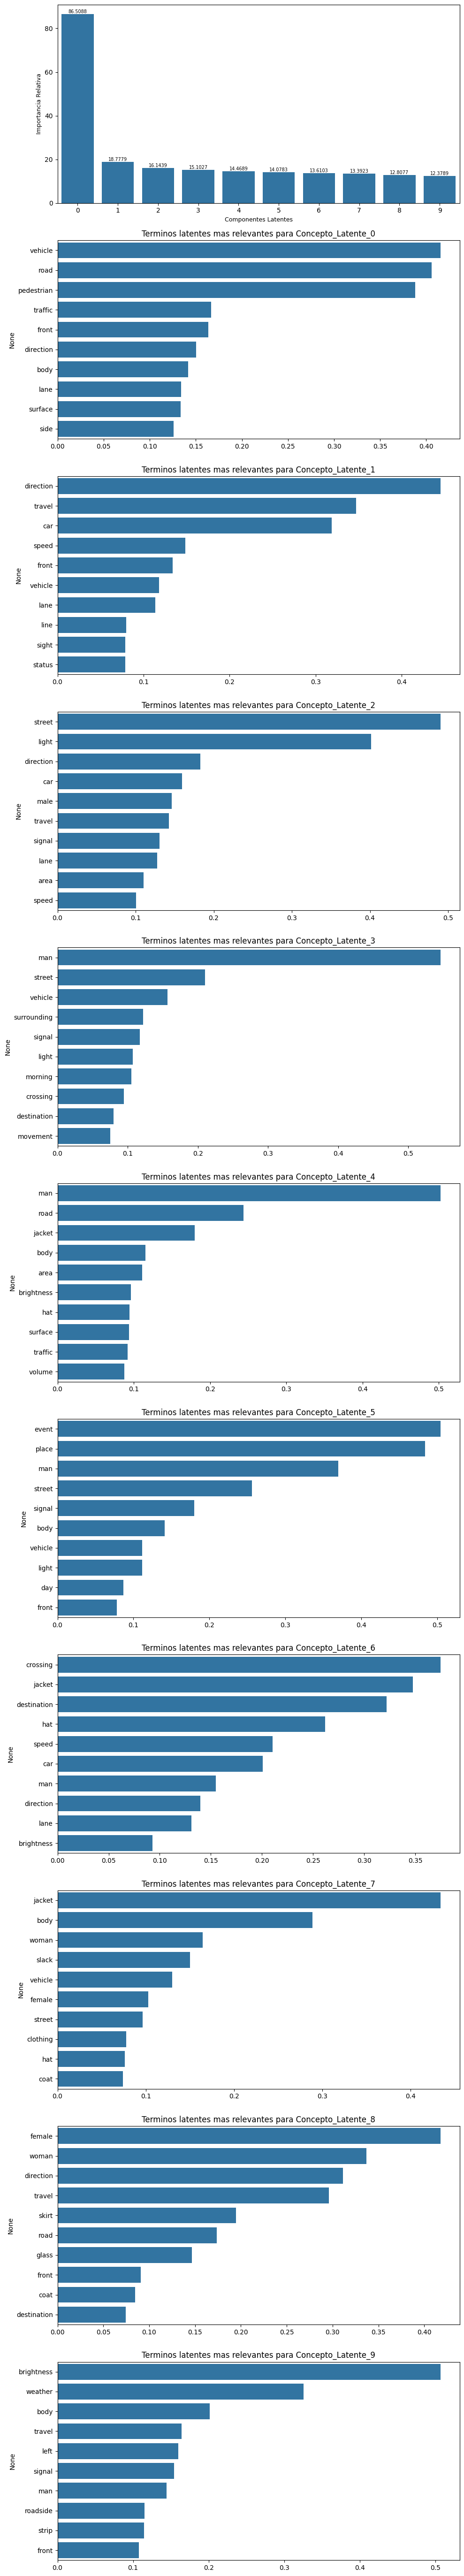

CPU times: user 9.25 s, sys: 218 ms, total: 9.47 s
Wall time: 4.87 s


In [13]:
%%time
get_lsi(df, "lemmatized_caption_pedestrian")

SHAPE OF DF (18256, 12)
SVD explained variance ratio sum: 0.23943463239926616
SHAPE term topic matrix: (694, 10)


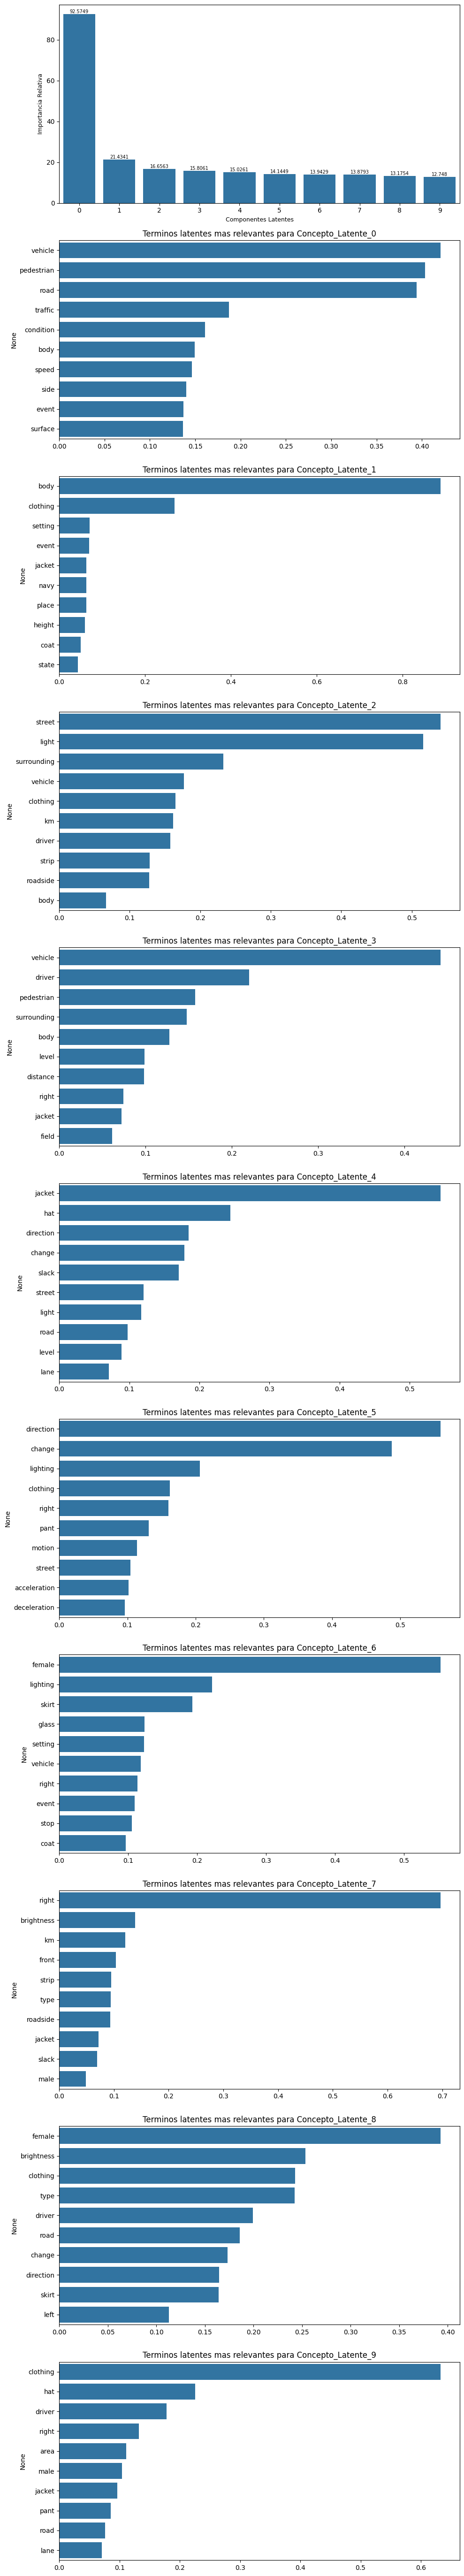

CPU times: user 8.31 s, sys: 156 ms, total: 8.46 s
Wall time: 4.24 s


In [14]:
%%time
get_lsi(df, "lemmatized_caption_vehicle")

In [15]:
df.head()

,id,video_name,fps,label,caption_pedestrian,caption_vehicle,start_time,end_time,lemmatized_caption_pedestrian_tokens,lemmatized_caption_pedestrian,lemmatized_caption_vehicle_tokens,lemmatized_caption_vehicle
0,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,prerecognition,"The pedestrian, a woman in her 50s, stood diag...","The vehicle, traveling at a constant speed of ...",35.073,35.106,"[pedestrian, woman, left, front, vehicle, week...",pedestrian woman left front vehicle weekday co...,"[vehicle, speed, right, front, pedestrian, veh...",vehicle speed right front pedestrian vehicle f...
1,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,recognition,"The pedestrian, a female in her 50s, stood dia...",The vehicle was moving at a constant speed of ...,35.139,35.172,"[pedestrian, female, left, front, vehicle, ori...",pedestrian female left front vehicle orientati...,"[vehicle, speed, right, front, pedestrian, veh...",vehicle speed right front pedestrian vehicle p...
2,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,judgement,"The pedestrian, a woman in her 50s with a heig...",The vehicle is moving at a constant speed of 1...,35.206,35.239,"[pedestrian, woman, height, cm, coat, slack, f...",pedestrian woman height cm coat slack front ri...,"[vehicle, speed, right, front, pedestrian, veh...",vehicle speed right front pedestrian vehicle v...
3,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,action,"A female pedestrian in her 50s, approximately ...",The vehicle was traveling at a constant speed ...,35.272,35.805,"[pedestrian, cm, coat, slack, left, front, veh...",pedestrian cm coat slack left front vehicle we...,"[vehicle, speed, km, right, front, pedestrian,...",vehicle speed km right front pedestrian distan...
4,2dd1fd1e-e470-4c93-90e0-47c51e5a3c11,video1098.mp4,30.052,avoidance,"The pedestrian is a woman in her 50s, standing...",The vehicle was traveling at a constant speed ...,35.838,38.234,"[pedestrian, woman, height, cm, left, front, v...",pedestrian woman height cm left front vehicle ...,"[vehicle, speed, right, front, pedestrian, vie...",vehicle speed right front pedestrian viewpoint...


## LSI per event phase

In [16]:
def filtrar_por_label(df, filter_label):
    return df[df['label'] == filter_label]

In [17]:
opciones_labels = df['label'].unique()
print(opciones_labels)

['prerecognition' 'recognition' 'judgement' 'action' 'avoidance']


shape = (3651, 12)
SHAPE OF DF (3651, 12)
SVD explained variance ratio sum: 0.205917112475237
SHAPE term topic matrix: (641, 10)


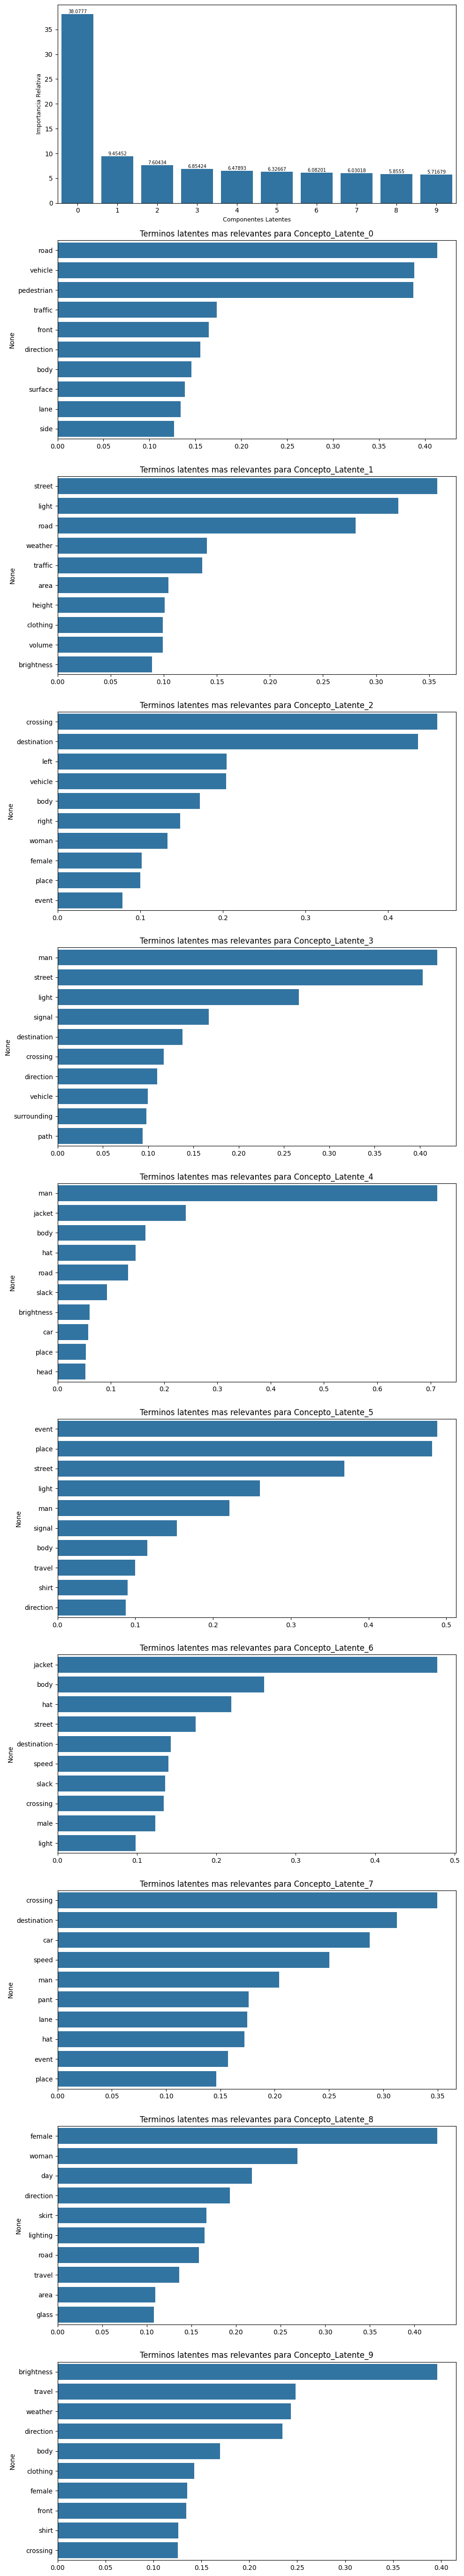

CPU times: user 3.91 s, sys: 76.2 ms, total: 3.99 s
Wall time: 2.68 s


In [18]:
%%time
df_tmp = filtrar_por_label(df, "prerecognition")
print(f"shape = {df_tmp.shape}")
get_lsi(df_tmp, "lemmatized_caption_pedestrian", r=10, t=10)

shape = (3651, 12)
SHAPE OF DF (3651, 12)
SVD explained variance ratio sum: 0.20032682549811232
SHAPE term topic matrix: (641, 10)


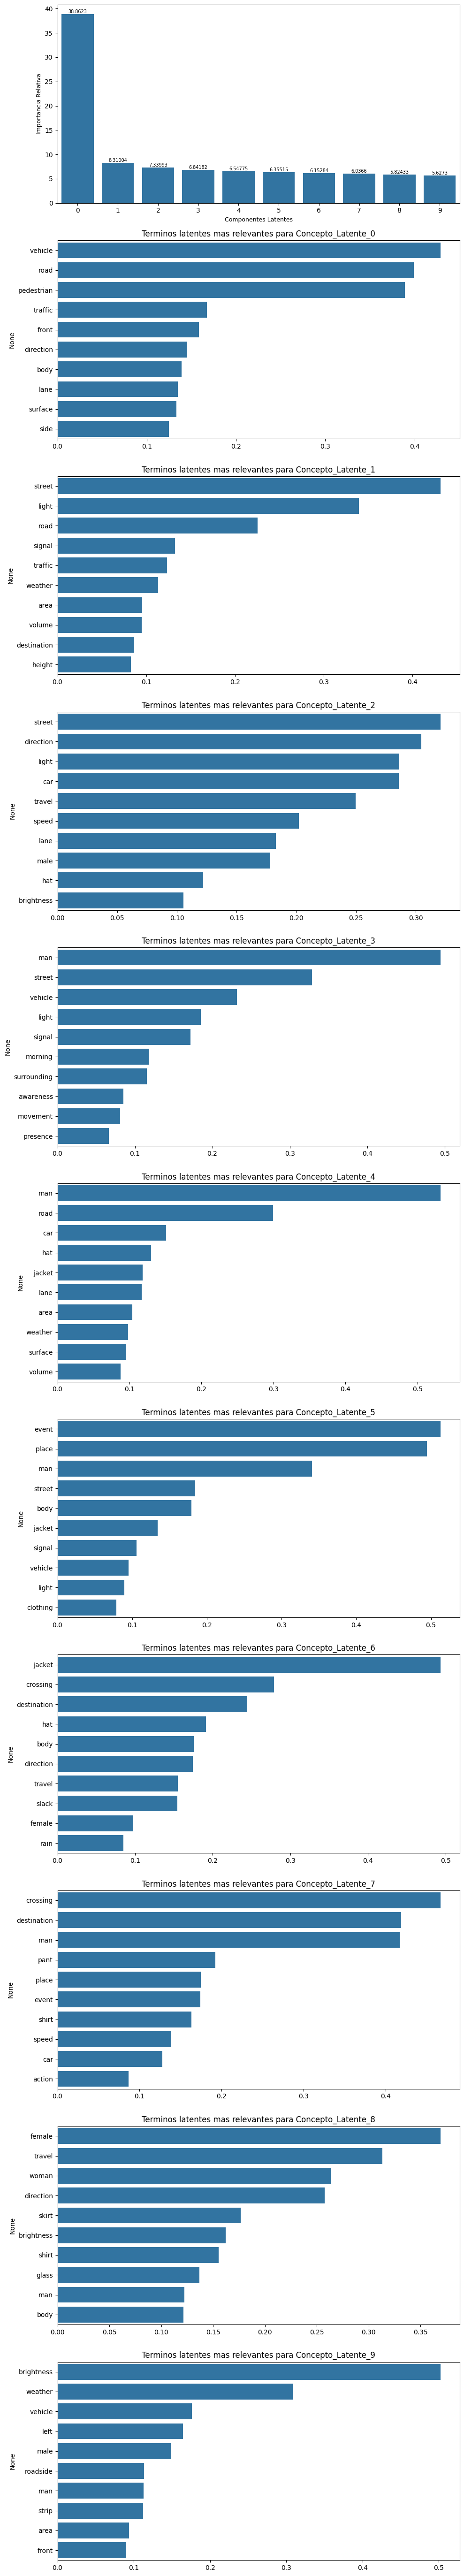

CPU times: user 4.3 s, sys: 54.3 ms, total: 4.35 s
Wall time: 2.95 s


In [19]:
%%time
df_tmp = filtrar_por_label(df, "recognition")
print(f"shape = {df_tmp.shape}")
get_lsi(df_tmp, "lemmatized_caption_pedestrian", r=10, t=10)

shape = (3652, 12)
SHAPE OF DF (3652, 12)
SVD explained variance ratio sum: 0.20560682376578865
SHAPE term topic matrix: (618, 10)


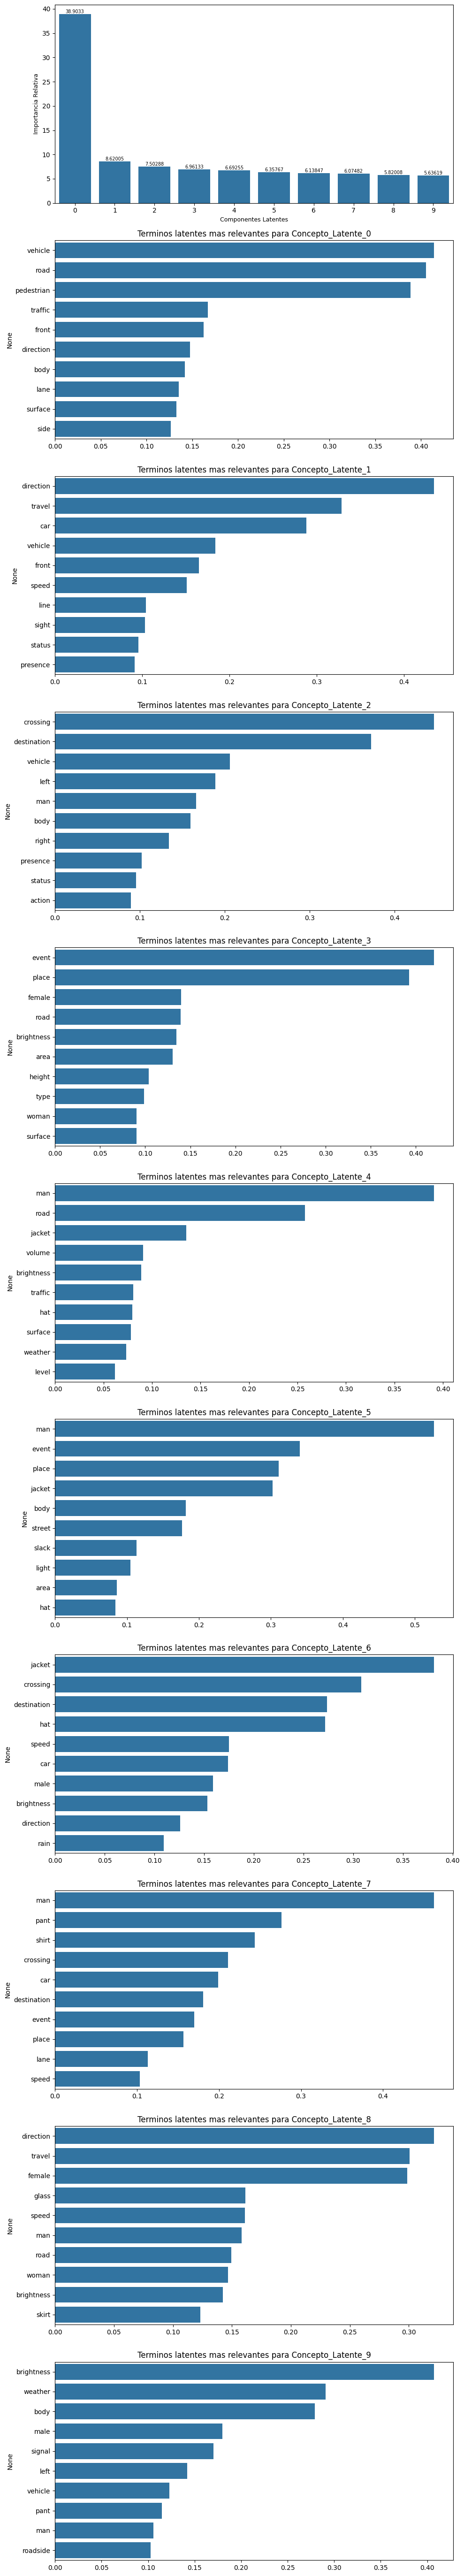

CPU times: user 3.95 s, sys: 35.6 ms, total: 3.99 s
Wall time: 2.56 s


In [20]:
%%time
df_tmp = filtrar_por_label(df, "judgement")
print(f"shape = {df_tmp.shape}")
get_lsi(df_tmp, "lemmatized_caption_pedestrian", r=10, t=10)

shape = (3651, 12)
SHAPE OF DF (3651, 12)
SVD explained variance ratio sum: 0.19929477207303778
SHAPE term topic matrix: (591, 10)


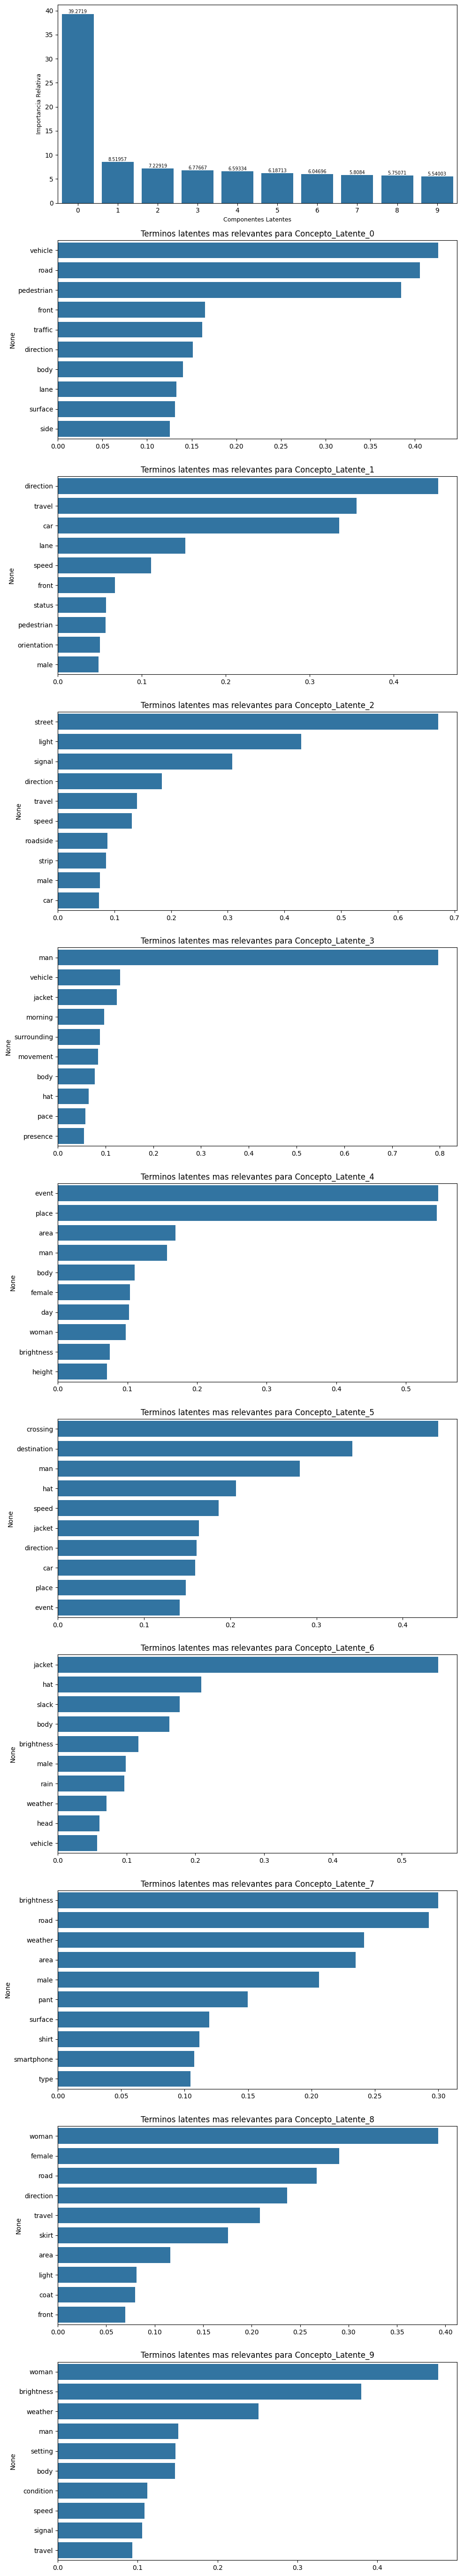

CPU times: user 3.63 s, sys: 44.5 ms, total: 3.67 s
Wall time: 2.46 s


In [21]:
%%time
df_tmp = filtrar_por_label(df, "action")
print(f"shape = {df_tmp.shape}")
get_lsi(df_tmp, "lemmatized_caption_pedestrian", r=10, t=10)

shape = (3651, 12)
SHAPE OF DF (3651, 12)
SVD explained variance ratio sum: 0.19553836944313902
SHAPE term topic matrix: (586, 10)


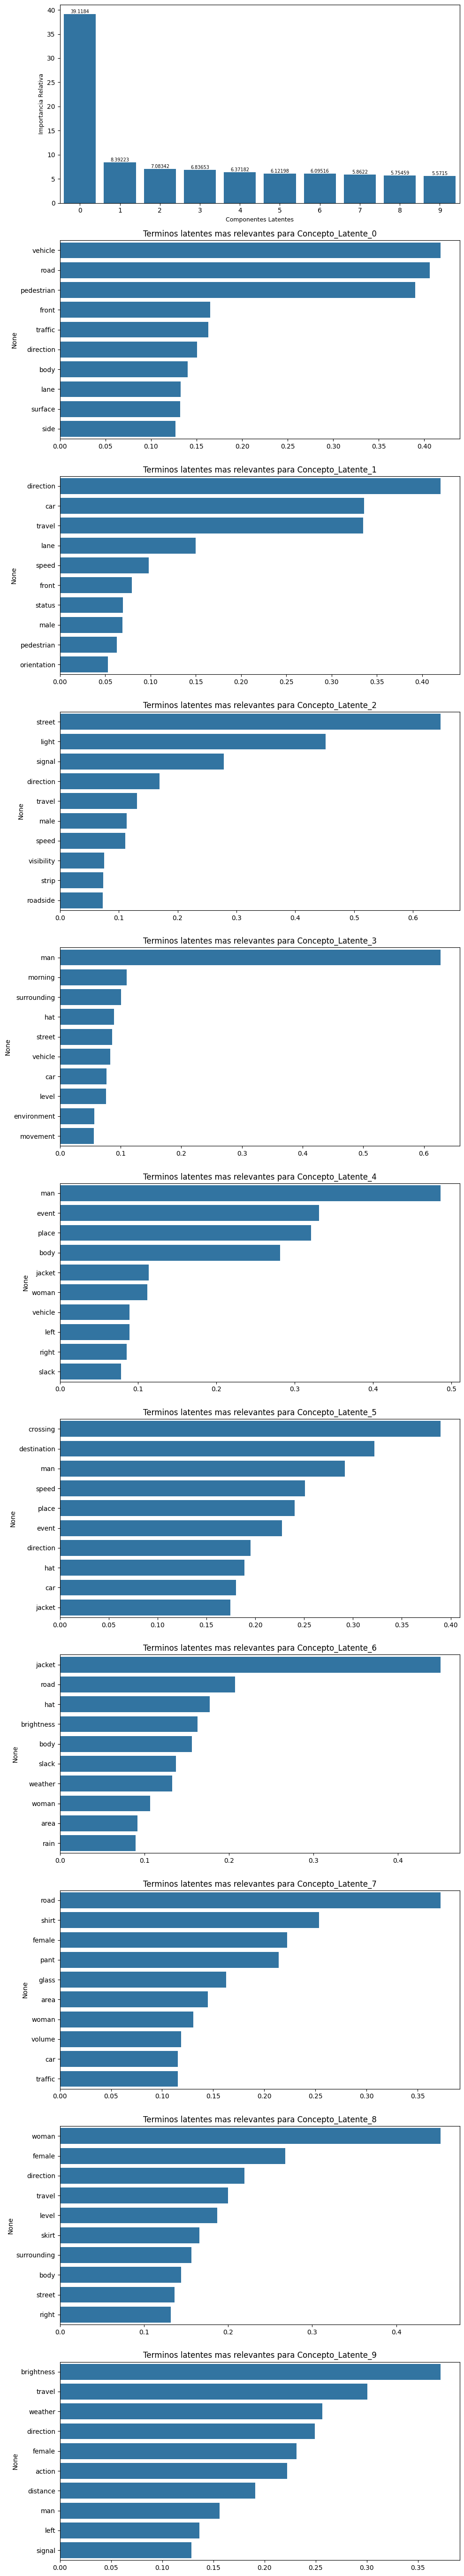

CPU times: user 3.87 s, sys: 31.1 ms, total: 3.9 s
Wall time: 2.77 s


In [22]:
%%time
df_tmp = filtrar_por_label(df, "avoidance")
print(f"shape = {df_tmp.shape}")
get_lsi(df_tmp, "lemmatized_caption_pedestrian", r=10, t=10)